In [1]:
import numpy as np  
import matplotlib.pyplot as mtp  
import pandas as pd

In [2]:
train_data = pd.read_csv(r'trainAssignment.csv',low_memory = False)
test_data = pd.read_csv(r'testAssignment.csv',low_memory = False)
train_data.shape,test_data.shape

((5000, 28), (500, 28))

In [4]:
x_train = train_data.iloc[:, :-1] # features of train dataset
y_train = train_data.iloc[:, -1] # labels of train dataset
x_test = test_data.iloc[:, :-1] # features of test dataset
y_test = test_data.iloc[:, -1] # labels of test dataset
# y_test # it is the one we need to predict

Exploring different ways to split data for cross validation

sklearn provides three methods to divide data into train/test sets:

    ShuffleSplit
        Random sampling
    Kfold
        Ordered sampling
    StratifiedKFold
        Stratified sampling

we use each of the above methods to create a 10 fold split of the data for cross validation and visualise the splits.

In [6]:
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit

In [7]:
# Randomly splits the data into a training set and a test set multiple times.
ss = ShuffleSplit(n_splits=10, test_size=15, random_state=4)

# This is non-random sampling, we just break the data in to 10 contiguous sub-sets
# Divides data into k folds where each fold is used once as a test set while the remaining are used as training sets.
kf = KFold(n_splits=10)

# variation of K-Fold which ensures that each fold contains approximately the same percentage of samples of each class. 
# Useful for imbalanced datasets.
skf = StratifiedKFold(n_splits=10)

In [8]:
# This cell sets up a nice visulisation that I found on the scikit-learn documentation page.
import matplotlib.pyplot as plt
#  Patch module is used for creating legends in plots.
from matplotlib.patches import Patch 
# it is a color map that provides a set of paired colors.
cmap_data = plt.cm.Paired 
# plt.cm.coolwarm is a gradient color map ranging from cool (blue) to warm (red) colors, suitable for highlighting
# differences across cross-validation splits.
cmap_cv = plt.cm.coolwarm 

In [9]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """
    Create a sample plot for indices of a cross-validation object.
    Parameters
    ----------
    cv: cross validation method
    X : training data
    y : data labels
    group : group labels
    ax : matplolib axes object
    n_splits : number of splits
    lw : line width for plotting
    """

    # Generate the training/testing visualizations for each Cross Validation split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

C:\Users\sanja\AppData\Local\Temp\ipykernel_2000\3882111905.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(range(len(X)), [ii + 2.5] * len(X),
C:\Users\sanja\AppData\Local\Temp\ipykernel_2000\3882111905.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(range(len(X)), [ii + 2.5] * len(X),
C:\Users\sanja\AppData\Local\Temp\ipykernel_2000\3882111905.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(range(len(X)), [ii + 2.5] * len(X),


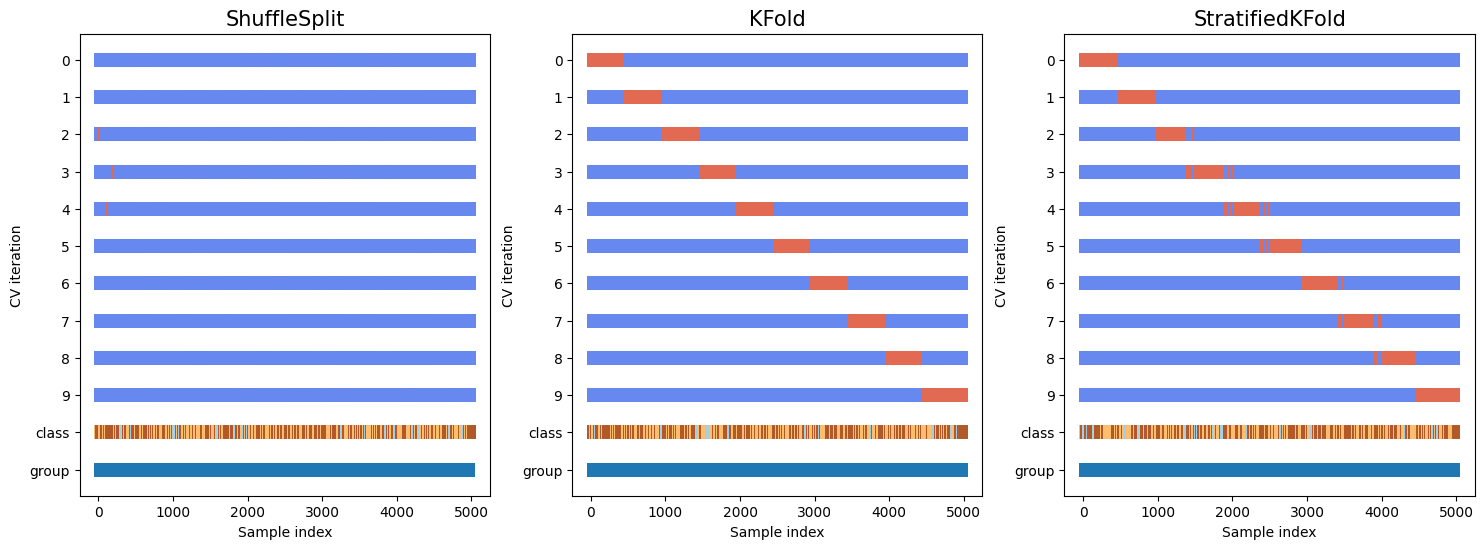

In [12]:
# Set up a figure with three subplots
fig, ax = plt.subplots(1,3, figsize=(18,6))
# visualise the ShulffleSplit algorithm
plot_cv_indices(ss,
                x_train,
                y_train,
                group=None,
                ax=ax[0],
                n_splits=10)
# visualise the KFolds algorithm
plot_cv_indices(kf,
                x_train,
                y_train,
                group=None,
                ax=ax[1],
                n_splits=10)
# visualise the StratifiedKFolds algorithm
plot_cv_indices(skf,
                x_train,
                y_train,
                group=None,
                ax=ax[2],
                n_splits=10)
plt.show()

# now using knn classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [21]:
# Create a dictionary of all the parameters we'll be iterating over
parameters = {'weights': ('uniform','distance'), # this should be the different weighting schemes
              'n_neighbors':[1,3,7,11,21]} # this should be a list of the nearest neigbhours
# make a classifier object
knn = KNeighborsClassifier()
# create a GridSearchCV object to do the training with cross validation
gscv = GridSearchCV(estimator=knn,
                    param_grid=parameters,
                    cv=ss,  # the cross validation folding pattern i.e. StratifiredKFold
                    scoring='accuracy')
# now train our model
best_knn = gscv.fit(x_train, y_train)

In [22]:
best_knn.best_params_, best_knn.best_score_

({'n_neighbors': 3, 'weights': 'distance'}, np.float64(0.5333333333333334))

- ({'n_neighbors': 3, 'weights': 'distance'}, np.float64(0.5333333333333334)) using ss
- ({'n_neighbors': 21, 'weights': 'distance'}, np.float64(0.49779999999999996)) using kf
- ({'n_neighbors': 21, 'weights': 'distance'}, np.float64(0.4798)) using skv

Now that we know what the best parameters are to use, we make a new version of our classifier and train it with all the training data.

In [24]:
knn = KNeighborsClassifier(weights = best_knn.best_params_['weights'],
                            n_neighbors = best_knn.best_params_['n_neighbors'])
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

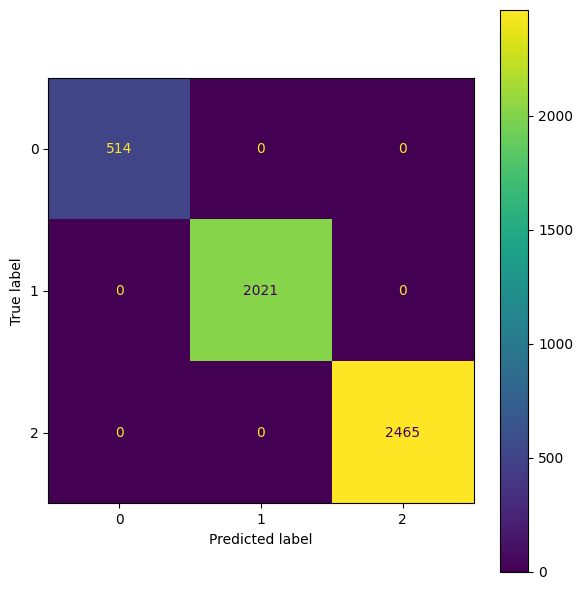

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))
# drwing a confusion matrix
ConfusionMatrixDisplay.from_estimator(best_knn,
                                      x_train, y_train,
                                      ax=ax)
plt.tight_layout()
plt.show()